### Загружаем данные для обучения: `train_texts`, `val_texts`, `test_texts`

In [1]:
from datasets import load_dataset

from sklearn.model_selection import train_test_split

from os.path import isfile

from src.data_utils import clean_text

import pandas as pd

import numpy as np

import os


train_texts, val_texts, test_texts = None, None, None
foldername = 'data'
raw_dataset_filepath = os.path.join(foldername, 'raw_dataset.csv')
processed_dataset_filepath = os.path.join(foldername, 'processed_dataset.csv')
train_filepath = os.path.join(foldername, 'train.csv')
val_filepath = os.path.join(foldername, 'val.csv')
test_filepath = os.path.join(foldername, 'test.csv')
text_column = 'text'

# Если такие файлы уже есть, загружаем данные для обучения из них
if isfile(train_filepath) and isfile(val_filepath) and isfile(test_filepath):
    train_texts = pd.read_csv(train_filepath).dropna()[text_column].to_list()
    val_texts = pd.read_csv(val_filepath).dropna()[text_column].to_list()
    test_texts = pd.read_csv(test_filepath).dropna()[text_column].to_list()
# В противном случае скачиваем датасет, обрабатываем, делим его на выборки и сохраняем
else:
    dataset = load_dataset('sentiment140', trust_remote_code=True, split='train', cache_dir='data')['text']
    dataset_df = pd.DataFrame({ text_column: dataset })
    dataset_df.to_csv(raw_dataset_filepath, index=False)

    texts = list(map(clean_text, dataset))
    print(len(texts))
    texts_df = pd.DataFrame({ text_column: texts })
    texts_df.to_csv(processed_dataset_filepath, index=False)

    val_test = 0.2
    test = 0.5
    train_texts, val_test_texts = train_test_split(texts, test_size=val_test, random_state=42)
    val_texts, test_texts = train_test_split(val_test_texts, test_size=test)

    train_df = pd.DataFrame({ text_column: train_texts })
    train_df.to_csv(train_filepath, index=False)

    test_df = pd.DataFrame({ text_column: test_texts })
    test_df.to_csv(test_filepath, index=False)

    val_df = pd.DataFrame({ text_column: val_texts })
    val_df.to_csv(val_filepath, index=False)

/home/ubuntu/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating test split: 100%|██████████| 498/498 [00:00<00:00, 26545.55 examples/s]


1600000


### Из полученных данных формируем датасеты

Я использовала посимвольную токенизацию, так как она, на мой взгляд, лучше подходит для LSTM автодополнений, чем разбиение на подслова, как в bert-base-uncased.

In [5]:
from torch.utils.data import DataLoader

from src.next_token_dataset import NextTokenDataset, EvalROUGEDataset, collate_fn, collate_fn_rouge_ds
from src.char_tokenizer import CharTokenizer


tokenizer = CharTokenizer()

batch_size = 256

sorted_ids = np.argsort([len(text) for text in train_texts])
train_texts = np.array(train_texts)[sorted_ids]
train_dataset = NextTokenDataset(train_texts, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

sorted_ids = np.argsort([len(text) for text in val_texts])
val_texts = np.array(val_texts)[sorted_ids]
val_dataset = NextTokenDataset(val_texts, tokenizer)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)

# Датасет для вычисления метрик ROUGE на валидационных данных
val_rouge_dataset = EvalROUGEDataset(val_texts, tokenizer)
val_rouge_dataloader = DataLoader(val_rouge_dataset, batch_size=batch_size, collate_fn=collate_fn_rouge_ds)

sorted_ids = np.argsort([len(text) for text in test_texts])
test_texts = np.array(test_texts)[sorted_ids]
test_dataset = EvalROUGEDataset(test_texts, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn_rouge_ds)

### Обучаем модель:

In [6]:
from src.lstm_model import LSTMAutoComplete
from src.model_train import train_one_epoch
from src.model_eval import evaluate_model

from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt

import torch.nn as nn
import torch

import os


device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Определяем модель:
## 2 скрытых слоя
## размерность скрытого состояния 512
model = LSTMAutoComplete(len(tokenizer.vocab), pad_token_id=tokenizer.pad_token_id, hidden_size=512, num_layers=2)

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = StepLR(optimizer, 5, 0.5)
criterion = nn.CrossEntropyLoss(ignore_index=0)
epochs = 12
last_epoch = epochs
test_phrase = "what are you talking"

# Посмотрим на валидационные метрики до обучения:
print('=== Before training ===')
evaluate_model(model, tokenizer, device, val_dataloader, val_rouge_dataloader, criterion, test_phrase=test_phrase)
print('===================================\n')

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 3
patience_counter = 0

# Сюда будет сохраняться лучшая модель
folder = 'checkpoints'
os.makedirs(folder, exist_ok=True)
PATH = os.path.join(folder, 'best_model.pth')

# Обучаем модель в течение 20-ти эпох
for epoch in range(1, epochs+1):
    train_loss = train_one_epoch(model, device, epoch, train_dataloader, optimizer, criterion, scheduler)
    val_loss = evaluate_model(model, tokenizer, device, val_dataloader, val_rouge_dataloader, criterion, test_phrase=test_phrase)
    print('===================================\n')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if abs(val_loss - best_val_loss) < 1e-4:
        best_val_loss = val_loss
#       Сохраним лучшую модель
        torch.save(model.state_dict(), PATH)        
        patience_counter +=1
        if patience_counter >= patience:
            print('Early stopping triggered...')
            last_epoch = epoch
            break
    else:
        patience_counter = 0

# Сохраним результаты обучения
torch.save(model.state_dict(), PATH)
plt.plot(list(range(1, last_epoch+1)), train_losses, color='b', label='train loss')
plt.plot(list(range(1, last_epoch+1)), val_losses, color='g', label='val loss')
plt.legend()
plt.show()

=== Before training ===


Evaluating ROUGE: 100%|██████████| 620/620 [10:10<00:00,  1.02it/s]


Validation loss: 3.931639345999687
Rouge metrics:
rouge1: 0.0030
rouge2: 0.0000
rougeL: 0.0030
rougeLsum: 0.0030
what are you talking 6gyjzl"2xy;-;;)5ss6;24?alcp(!q?tbtuizp3j



Training epoch 1: 100%|██████████| 4963/4963 [24:15<00:00,  3.41it/s]


Epoch: 1, training loss: 1.4767


Evaluating ROUGE: 100%|██████████| 620/620 [10:22<00:00,  1.00s/it]


Validation loss: 1.3481774447425718
Rouge metrics:
rouge1: 0.1033
rouge2: 0.0067
rougeL: 0.1032
rougeLsum: 0.1032
what are you talking  gogglegh as how it will probably start 



Training epoch 2: 100%|██████████| 4963/4963 [24:11<00:00,  3.42it/s]


Epoch: 2, training loss: 1.3397


Evaluating ROUGE: 100%|██████████| 620/620 [10:24<00:00,  1.01s/it]


Validation loss: 1.324023180046389
Rouge metrics:
rouge1: 0.1098
rouge2: 0.0082
rougeL: 0.1095
rougeLsum: 0.1096
what are you talking  on m? don't work 30!



Training epoch 3: 100%|██████████| 4963/4963 [24:24<00:00,  3.39it/s]


Epoch: 3, training loss: 1.3193


Evaluating ROUGE: 100%|██████████| 620/620 [10:19<00:00,  1.00it/s]


Validation loss: 1.3088454013870607
Rouge metrics:
rouge1: 0.1108
rouge2: 0.0086
rougeL: 0.1107
rougeLsum: 0.1107
what are you talking  short orders turn in the itl? car was 1



Training epoch 4: 100%|██████████| 4963/4963 [24:24<00:00,  3.39it/s]


Epoch: 4, training loss: 1.3086


Evaluating ROUGE: 100%|██████████| 620/620 [10:17<00:00,  1.00it/s]


Validation loss: 1.2966407623983198
Rouge metrics:
rouge1: 0.1140
rouge2: 0.0090
rougeL: 0.1138
rougeLsum: 0.1138
what are you talking  about?gt;



Training epoch 5: 100%|██████████| 4963/4963 [24:14<00:00,  3.41it/s]


Epoch: 5, training loss: 1.3020


Evaluating ROUGE: 100%|██████████| 620/620 [10:24<00:00,  1.01s/it]


Validation loss: 1.2951954551281468
Rouge metrics:
rouge1: 0.1134
rouge2: 0.0090
rougeL: 0.1133
rougeLsum: 0.1133
what are you talking  about the lime by the tree micky now? m



Training epoch 6: 100%|██████████| 4963/4963 [24:14<00:00,  3.41it/s]


Epoch: 6, training loss: 1.2800


Evaluating ROUGE: 100%|██████████| 620/620 [10:23<00:00,  1.01s/it]


Validation loss: 1.2724119384442607
Rouge metrics:
rouge1: 0.1173
rouge2: 0.0101
rougeL: 0.1172
rougeLsum: 0.1172
what are you talking  about



Training epoch 7: 100%|██████████| 4963/4963 [24:12<00:00,  3.42it/s]


Epoch: 7, training loss: 1.2763


Evaluating ROUGE: 100%|██████████| 620/620 [10:11<00:00,  1.01it/s]


Validation loss: 1.270834070059561
Rouge metrics:
rouge1: 0.1173
rouge2: 0.0100
rougeL: 0.1172
rougeLsum: 0.1172
what are you talking  about? that is beer than my lile boy in



Training epoch 8: 100%|██████████| 4963/4963 [24:24<00:00,  3.39it/s]


Epoch: 8, training loss: 1.2739


Evaluating ROUGE: 100%|██████████| 620/620 [10:29<00:00,  1.01s/it]


Validation loss: 1.2689260052096458
Rouge metrics:
rouge1: 0.1181
rouge2: 0.0103
rougeL: 0.1179
rougeLsum: 0.1179
what are you talking  about?



Training epoch 9:   0%|          | 11/4963 [00:03<23:01,  3.59it/s]


KeyboardInterrupt: 

Я была вынуждена вручную прервать обучение, так как время работы виртуальной машины ограничего, а модель обучалась дольше ожидаемого времени (так как я использовала посимвольную токенизацию, из-за этого длина каждого сэмпла в токенах увеличилась в несколько раз).

Однако validation_loss уже перестала значительно уменьшаться, а метрика rouge перестала значительно расти.

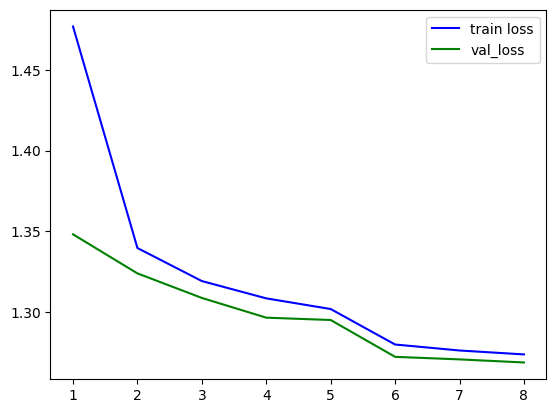

In [7]:
# Сохраним модель и отобразим графики значения функци потерь
torch.save(model.state_dict(), PATH)
plt.plot(list(range(1, 9)), train_losses, color='b', label='train loss')
plt.plot(list(range(1, 9)), val_losses, color='g', label='val_loss')
plt.legend()
plt.show()

In [20]:
from transformers import pipeline

generator = pipeline('text-generation', model='distilgpt2', batch_size=batch_size, device=device, truncation=True)
generator.tokenizer.pad_token_id = generator.tokenizer.eos_token_id
generator.tokenizer.padding_side = 'left'

Device set to use cuda


In [23]:
from transformers.utils import logging

logging.set_verbosity_error()

### Теперь на тестовых данных сравним работу LSTM модели и GPT2:

In [24]:
from src.gpt_vs_lstm_eval import evaluate_gpt_vs_lstm

evaluate_gpt_vs_lstm(model, generator, tokenizer, test_dataloader, batch_size=batch_size, device=device)

Autocompleting inputs: 100%|██████████| 621/621 [19:58<00:00,  1.93s/it]


Rouge metrics for test (GPT2):
rouge1: 0.0255
rouge2: 0.0015
rougeL: 0.0246
rougeLsum: 0.0247
Rouge metrics for test (LSTM-based):
rouge1: 0.1168
rouge2: 0.0101
rougeL: 0.1167
rougeLsum: 0.1167
=== Samples ===
Input: "bea"
	GPT2-autocomplete: "-beige"
	LSTM-autocomplete: "ch, "

Input: "tha"
	GPT2-autocomplete: " a.j"
	LSTM-autocomplete: "nks "

Input: "gd "
	GPT2-autocomplete: "_____________________________________________________________________________"
	LSTM-autocomplete: " n"

Input: "hi col"
	GPT2-autocomplete: "son@gmail"
	LSTM-autocomplete: "in"

Input: "gdnigh"
	GPT2-autocomplete: ": i love it"
	LSTM-autocomplete: "t c"

